# **Data Analysis & Statistics 🔎**

This notebook contains a comprehensive statistical analysis of the `pokemon_cards.csv` dataset. The dataset encompasses detailed information about Pokémon trading cards, including card names, rarity classifications, pricing data (holofoil and reverse holofoil variants), release dates, and popularity rankings.

Here are the main steps of the analysis : 
1. Lasso Regression with cross-validation on specific parameters
2. Top 10 Series with the Most Expensive Cards
3. Top 10 Rarities with the Most Expensive Cards
4. Relationship between Popularity and Holofoil Price
5. Correlation Between Release Date and Holofoil Price
6. Top 10 Artists with the Most Expensive Cards
7. Top 10 Artists with Most Popular Cards

Importing Libraries and Loading the Pokémon Card Dataset


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LassoCV
import plotly.express as px
import matplotlib.font_manager as fm


file_path = "datas/pokemon_cards.csv"
data = pd.read_csv(file_path)


Previewing the Dataset

In [17]:
data.head(3)

,id,name,rarity,collection,series,holofoil_price,reverse_holofoil_price,release_date,nationalPokedexNumbers,artist,images_url,popularity_rank,average_price,processed_popularity
0,dp3-1,Ampharos,Rare Holo,Secret Wonders,Diamond & Pearl,14.73,9.99,2007-11-01,[181],Kouki Saitou,https://images.pokemontcg.io/dp3/1_hires.png,#41,12.36,41.0
3,sm9-1,Celebi & Venusaur-GX,Rare Holo GX,Team Up,Sun & Moon,12.45,NaN,2019-02-01,"[3, 251]",Mitsuhiro Arita,https://images.pokemontcg.io/sm9/1_hires.png,#84,12.45,84.0
4,pl1-2,Blastoise,Rare Holo,Platinum,Platinum,20.42,12.34,2009-02-11,[9],Kagemaru Himeno,https://images.pokemontcg.io/pl1/2_hires.png,#106,16.38,106.0


# **Useful Functions**
The `calculate_avg_price` function computes the average of the two prices, `holofoil_price` and `reverse_holofoil_price`, if both are available. If one of the prices is missing, it returns the available price.


In [5]:
def calculate_avg_price(row):
    """
    Calculate the average price for a Pokémon card.

    Parameters:
        row (pd.Series): A row from the DataFrame containing 'holofoil_price' and 'reverse_holofoil_price'.

    Returns:
        float: The average price if both prices are available.
               If only one price is available, returns that price.
               Returns NaN if both prices are missing.
    """
    if pd.notnull(row['holofoil_price']) and pd.notnull(row['reverse_holofoil_price']):
        return (row['holofoil_price'] + row['reverse_holofoil_price']) / 2
    elif pd.notnull(row['holofoil_price']):
        return row['holofoil_price']
        return row['reverse_holofoil_price']



The function `preprocess_popularity` processes the `popularite` column by handling non-referenced values and extracting numeric rankings.

In [6]:
def preprocess_popularity(value):
    """
    Process the 'popularite' column to handle non-referenced values and extract rankings.

    Parameters:
        value (str): The raw value from the 'popularite' column.

    Returns:
        int or float: The processed popularity ranking.
                     -1 for non-referenced cards, integer rank for valid ranks, or NaN for invalid values.
    """
    if value == "Non référencé":
        return -1
    elif isinstance(value, str) and value.startswith("#"):
        return int(value[1:])
    else:
        return np.nan


Visualization of the dataset after modifications

In [8]:

# Apply the function to calculate the average price
data['average_price'] = data.apply(calculate_avg_price, axis=1)

# Apply the function to preprocess the popularity column
data['processed_popularity'] = data['popularity_rank'].apply(preprocess_popularity)

# Convert release_date to datetime
data['release_date'] = pd.to_datetime(data['release_date'], errors='coerce')

# Drop rows with completely missing values for key features
data = data.dropna(subset=['average_price', 'processed_popularity', 'release_date'])

data.head()

,id,name,rarity,collection,series,holofoil_price,reverse_holofoil_price,release_date,nationalPokedexNumbers,artist,images_url,popularity_rank,average_price,processed_popularity
0,dp3-1,Ampharos,Rare Holo,Secret Wonders,Diamond & Pearl,14.73,9.99,2007-11-01,[181],Kouki Saitou,https://images.pokemontcg.io/dp3/1_hires.png,#41,12.36,41.0
3,sm9-1,Celebi & Venusaur-GX,Rare Holo GX,Team Up,Sun & Moon,12.45,NaN,2019-02-01,"[3, 251]",Mitsuhiro Arita,https://images.pokemontcg.io/sm9/1_hires.png,#84,12.45,84.0
4,pl1-2,Blastoise,Rare Holo,Platinum,Platinum,20.42,12.34,2009-02-11,[9],Kagemaru Himeno,https://images.pokemontcg.io/pl1/2_hires.png,#106,16.38,106.0
5,ex3-2,Altaria,Rare Holo,Dragon,EX,20.35,14.97,2003-11-24,[334],Atsuko Nishida,https://images.pokemontcg.io/ex3/2_hires.png,#105,17.66,105.0
6,sm12-1,Venusaur & Snivy-GX,Rare Holo GX,Cosmic Eclipse,Sun & Moon,8.31,NaN,2019-11-01,"[3, 495]",Mitsuhiro Arita,https://images.pokemontcg.io/sm12/1_hires.png,#104,8.31,104.0


# **Lasso Regression with cross-validation on specific parameters**

In [9]:

features = ['rarity', 'collection', 'series', 'release_date', 'artist', 'processed_popularity']
target = 'average_price'


data.dropna(subset=features + [target], inplace=True)


data_filtered = data[data['processed_popularity'] != -1]


if 'release_date' in features:
    data_filtered['release_date'] = pd.to_datetime(data_filtered['release_date'], errors='coerce').dt.year


categorical_features = ['rarity', 'collection', 'series', 'artist']
numerical_features = ['release_date', 'processed_popularity']


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ]
)


X = data_filtered[features]
y = data_filtered[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)


lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train_transformed, y_train)


y_pred = lasso.predict(X_test_transformed)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n=== Model Results ===")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Coefficient of Determination (R^2): {r2:.2f}")


feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist() + numerical_features
importance = pd.DataFrame({"Feature": feature_names, "Importance": lasso.coef_}).sort_values(by="Importance", ascending=False)
print("\nFeature Importance:")
print(importance)


example_cards = pd.DataFrame({
    'rarity': ['Rare', 'Ultra Rare'],
    'collection': ['Base Set', 'Fossil'],
    'series': ['Original Series', 'Original Series'],
    'release_date': [1999, 2000],
    'artist': ['Ken Sugimori', 'Mitsuhiro Arita'],
    'processed_popularity': [8, 50]
})


example_transformed = preprocessor.transform(example_cards)
predictions = lasso.predict(example_transformed)


print("\nPredictions for Example Cards:")
for i, pred in enumerate(predictions):
    print(f"Card {i+1}: Predicted Price = {pred:.2f}")


/var/folders/sg/lshv0q7145ggm8z9kc3b1y4r0000gn/T/ipykernel_24898/266759006.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=features + [target], inplace=True)



=== Model Results ===
Mean Squared Error (MSE): 8804.88
Coefficient of Determination (R^2): 0.46

Feature Importance:
                   Feature  Importance
13   rarity_Rare Holo Star  418.535563
162          series_E-Card  145.483609
246    artist_Naoyo Kimura  118.509583
20      rarity_Rare Secret   61.068008
33    collection_Aquapolis   31.362585
..                     ...         ...
172              series_XY  -12.514299
327   processed_popularity  -15.994976
5             rarity_Promo  -22.008551
326           release_date  -24.357213
9         rarity_Rare Holo  -51.228491

[328 rows x 2 columns]

Predictions for Example Cards:
Card 1: Predicted Price = 131.12
Card 2: Predicted Price = 116.58


**Model Performance:**

 - The model provides a moderate R² value of 0.46, suggesting it captures some of the relationships between features and card prices but does not explain a large portion of the variance. The MSE of 8804.88 indicates moderate prediction accuracy.

 - In conclusion, we are unable to predict a card’s price with high accuracy by relying solely on the card’s characteristics or the popularity of the Pokémon. Therefore, it is not relevant to use these features to construct an investment portfolio. This is why, in the second part, we focus on using historical prices of cards to make more reliable predictions and, consequently, build a better investment portfolio.

**Top Features with Positive Importance:**

  + rarity `Rare Holo Star` (418.53): The most important feature for predicting the price, suggesting that Pokémon cards with this rarity have a strong influence on the price. This may indicate that rare holo cards are more valuable.

  + series `E-Card` (145.48): Cards from the E-Card series also seem to have a significant impact on the price.

  + artist `Naoyo Kimura` (118.50): The positive coefficient for this artist indicates that cards illustrated by Naoyo Kimura tend to have higher predicted prices.

**Features with Negative Importance:**

  + `processed_popularity` (-15.65): The negative importance of popularity in the model suggests that higher popularity ranks (lower numerical values) tend to correlate with higher prices. Since the popularity rank is decreasing (with rank 1 being the most popular), a lower value for popularity means the card is more popular. Therefore, the negative coefficient suggests that more popular cards (lower popularity values) tend to have higher prices, which aligns with the expectation that highly sought-after cards are more valuable.

  + `release_date` (-23.49): The negative coefficient suggests that older cards tend to have slightly higher predicted prices. This could be due to the fact that vintage cards often have a higher value due to their rarity and historical significance in the market.

Although the prediction may not seem highly accurate, this regression allows us to **identify the most influential characteristics on the price** (both positively and negatively). 

In the next section of the statistical analysis, we will specifically focus on the features that have the **greatest impact** (either positive or negative). We will not pay too much attention to features close to zero, as this suggests they have little influence. In the statistical analysis, we will assess how impactful the characteristics identified by the regression are and determine if they are relevant.

# **Statistical analysis**

# **Top 10 Series with the Most Expensive Cards**

In [11]:
# Calculate the average price and the count of observations for each series
series_stats = data.groupby('series').agg(
    average_price=('average_price', 'mean'),
    count=('average_price', 'size')
).sort_values(by='average_price', ascending=False)

# Get the top 10 series based on average price
top_series = series_stats.head(10).reset_index()

fig = px.bar(
    top_series,
    x='average_price',
    y='series',
    orientation='h',
    color='average_price',
    color_continuous_scale='Viridis',
    title="Top 10 Series with the Most Expensive Cards",
    labels={'average_price': 'Average Price ($)', 'series': 'Series'}
)

# Add count of observations as text labels on the bars
fig.update_traces(text=top_series['count'], textposition='inside', insidetextanchor='start')

# Update the layout
fig.update_layout(
    title_font=dict(size=20, family='Arial', color='darkblue'),
    xaxis=dict(title_font=dict(size=16), tickfont=dict(size=14)),
    yaxis=dict(title_font=dict(size=16), tickfont=dict(size=14)),
    coloraxis_colorbar=dict(title="Price ($)", ticks="outside"),
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(240,248,255,0.9)',
)

fig.show()



It can be observed that the prices of cards from the E-card series are significantly higher than those from other series, with an average price of 161.64 USD, which is more than twice the average price of the second most expensive series, EX (80.56 USD). 

This confirms the high coefficient of the E-card series in the linear regression. Additionally, the number of observations is sufficiently large to suggest that this result is significant.

# **Top 10 Collections with the Most Expensive Cards**

In [12]:

collection_stats = data.groupby('collection').agg(
    average_price=('average_price', 'mean'),
    count=('average_price', 'size')
).sort_values(by='average_price', ascending=False)


top_collections = collection_stats.head(10).reset_index()


fig = px.bar(
    top_collections,
    x='average_price',
    y='collection',
    orientation='h',
    color='average_price',
    color_continuous_scale='Viridis',
    title="Top 10 Collections with the Most Expensive Cards",
    labels={'average_price': 'Average Price ($)', 'collection': 'Collection'}
)


fig.update_traces(text=top_collections['count'], textposition='inside', insidetextanchor='start')


fig.update_layout(
    title_font=dict(size=20, family='Arial', color='darkblue'),
    xaxis=dict(title_font=dict(size=16), tickfont=dict(size=14)),
    yaxis=dict(title_font=dict(size=16), tickfont=dict(size=14)),
    coloraxis_colorbar=dict(title="Price ($)", ticks="outside"),
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(240,248,255,0.9)',
)


fig.show()


We notice that the most expensive collection on average is Aquapolis, which is also present in the top 5 influential features on price according to the linear regression. However, in this case, we see that the top 5 most expensive collections have a price difference of around 50 USD, and the number of observations is under 30. Therefore, it is possible that the effect of the collection on the price may not be very significant.








# **Top 10 Rarities with the Most Expensive Cards**

In [13]:

rarity_stats = data.groupby('rarity').agg(
    average_price=('average_price', 'mean'),
    card_count=('average_price', 'count')
).sort_values(by='average_price', ascending=False).reset_index()


top_rarities = rarity_stats.head(10)


fig = px.bar(
    top_rarities,
    x='average_price',
    y='rarity',
    orientation='h',
    color='average_price',
    color_continuous_scale='Viridis',
    title="Top 10 Rarities with the Most Expensive Cards",
    labels={'average_price': 'Average Price ($)', 'rarity': 'Rarity'},
    text='card_count')


fig.update_traces(
    hovertemplate='<b>Rarity:</b> %{y}<br>' +
                  '<b>Average Price:</b> $%{x:.2f}<br>' +
                  '<b>Number of Cards:</b> %{text}<br>',
    textposition='outside')


fig.update_layout(
    title_font=dict(size=20, family='Arial', color='darkblue'),
    xaxis=dict(title_font=dict(size=16), tickfont=dict(size=14)),
    yaxis=dict(title_font=dict(size=16), tickfont=dict(size=14)),
    coloraxis_colorbar=dict(title="Price ($)", ticks="outside"),
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(240,248,255,0.9)',)

fig.show()


Regarding rarity, we notice a significant **difference between the price of Rare Holo Star cards and other rarities**, with an average price of **539 USD**, compared to 74 USD for the second rarity in the ranking. The number of observations for Rare Holo Star is very low (21 observations) compared to other rarities, which generally have more than 200 observations. This might lead us to believe that the rarity effect is biased by an overrepresentation of expensive cards, but this is not the case. Rare Holo Star cards are among the rarest, and it is logical that there are fewer copies in the database. 

In conclusion, the effect of rarity, specifically Rare Holo Star, is very significant, as indicated by the linear regression, which considers it the most influential feature on price. The low number of observations is justified by the rarity of this category.

# **Relationship between Popularity and Holofoil Price**

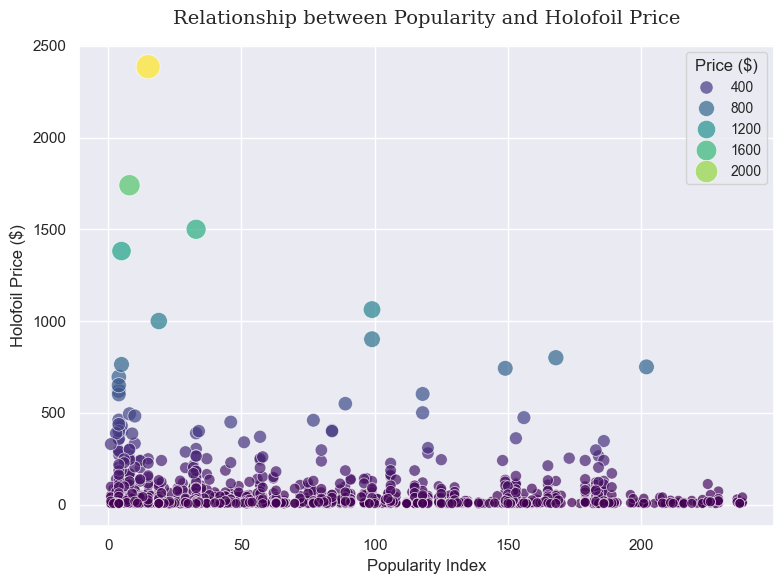

In [14]:
df_filtered = data[data['processed_popularity'] != -1]


sns.set_theme(style="darkgrid")
plt.figure(figsize=(8, 6))

scatter = sns.scatterplot(
    data=df_filtered,
    x='processed_popularity',
    y='holofoil_price',
    size='holofoil_price',
    sizes=(50, 300),
    alpha=0.7,
    hue='holofoil_price',
    palette='viridis'
)

plt.title('Relationship between Popularity and Holofoil Price',
    fontsize=14,
    pad=15,
    fontfamily='serif',
    fontweight='normal')

plt.xlabel('Popularity Index', fontsize=12)
plt.ylabel('Holofoil Price ($)', fontsize=12)

plt.legend(title='Price ($)', fontsize=10)
plt.tight_layout()
plt.show()

The graph shows a slight trend suggesting that the most popular cards are more likely to be very expensive. Most cards valued above $600 are within the top 25 of the popularity ranking and the top 3 most expensive cards are among the 20 most popular Pokémon. This indicates that the popularity of the Pokémon featured on the card can partially explain its price.

 This observation aligns with the linear regression results, which assign a negative coefficient to popularity. Since the "popularity" column represents a ranking, a lower rank corresponds to higher popularity, explaining the negative coefficient.

# **Correlation Between Release Date and Holofoil Price**

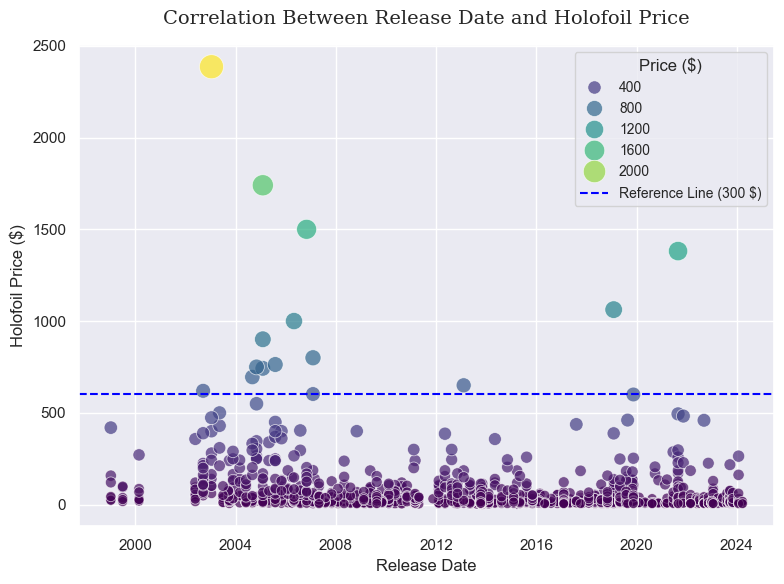

In [15]:

df_filtered = data[data['release_date'] != data['release_date'].max()]

sns.set_theme(style="darkgrid")

plt.figure(figsize=(8, 6))

scatter = sns.scatterplot(
    data=df_filtered,
    x='release_date',
    y='holofoil_price',
    size='holofoil_price',
    sizes=(50, 300),
    alpha=0.7,
    hue='holofoil_price',
    palette='viridis'
)

plt.axhline(y=600, color='blue', linestyle='--', label='Reference Line (300 $)')


plt.title('Correlation Between Release Date and Holofoil Price',
          fontsize=14,
          pad=15,
          fontfamily='serif',
          fontweight='normal')
plt.xlabel('Release Date', fontsize=12)
plt.ylabel('Holofoil Price ($)', fontsize=12)

plt.legend(title='Price ($)', fontsize=10)

plt.tight_layout()

plt.show()


We observe that most cards valued above 600 USD were produced between 2002 and 2007. Notably, three out of the five cards priced over 1,000 USD were produced during this period, as well as the only two cards exceeding 1,500 USD. Additionally, first editions are harder to find in good condition, which plays a significant role in determining a card's price. This could explain why the impact of a card's age on its price is not as pronounced as expected. In other words, older cards are more likely to be damaged, which reduces their value compared to their potential. Therefore, the effect of age on price is skewed by the card's condition.

# **Top 10 Artists with the Most Expensive Cards**

/var/folders/sg/lshv0q7145ggm8z9kc3b1y4r0000gn/T/ipykernel_24898/26429035.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




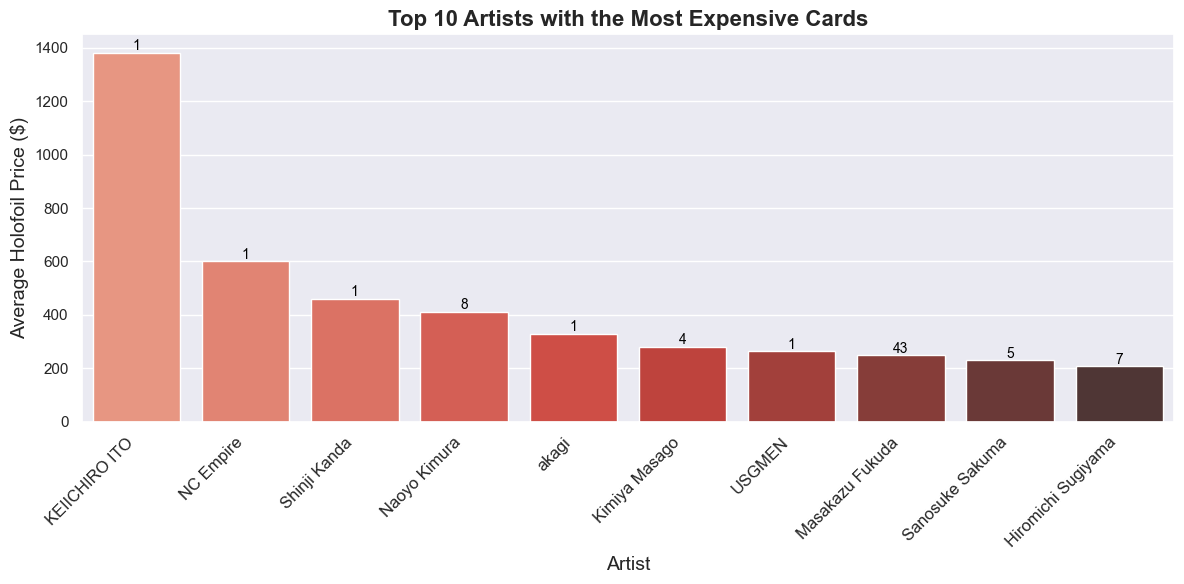

In [16]:

artist_stats = data.groupby('artist').agg(
    holofoil_price_mean=('holofoil_price', 'mean'),
    card_count=('holofoil_price', 'count')
).sort_values('holofoil_price_mean', ascending=False).head(10).reset_index()


plt.figure(figsize=(12, 6))
barplot = sns.barplot(
    x='artist',
    y='holofoil_price_mean',
    data=artist_stats,
    palette='Reds_d'
)


for index, row in artist_stats.iterrows():
    barplot.text(
        index,
        row['holofoil_price_mean'] + 10,
        f"{row['card_count']}",
        color='black',
        ha='center',
        fontsize=10
    )


plt.title('Top 10 Artists with the Most Expensive Cards', fontsize=16, weight='bold')
plt.xlabel('Artist', fontsize=14)
plt.ylabel('Average Holofoil Price ($)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()

plt.show()


We notice that among the top 10 artists with the highest average card prices, Naoyo Kimura stands out. Additionally, the number of observations in his column is 17, which is relatively significant compared to others with less than 4 observations.

# **Top 10 Artists with Most Popular Cards**

<ipython-input-48-e5ed54810ae7>:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




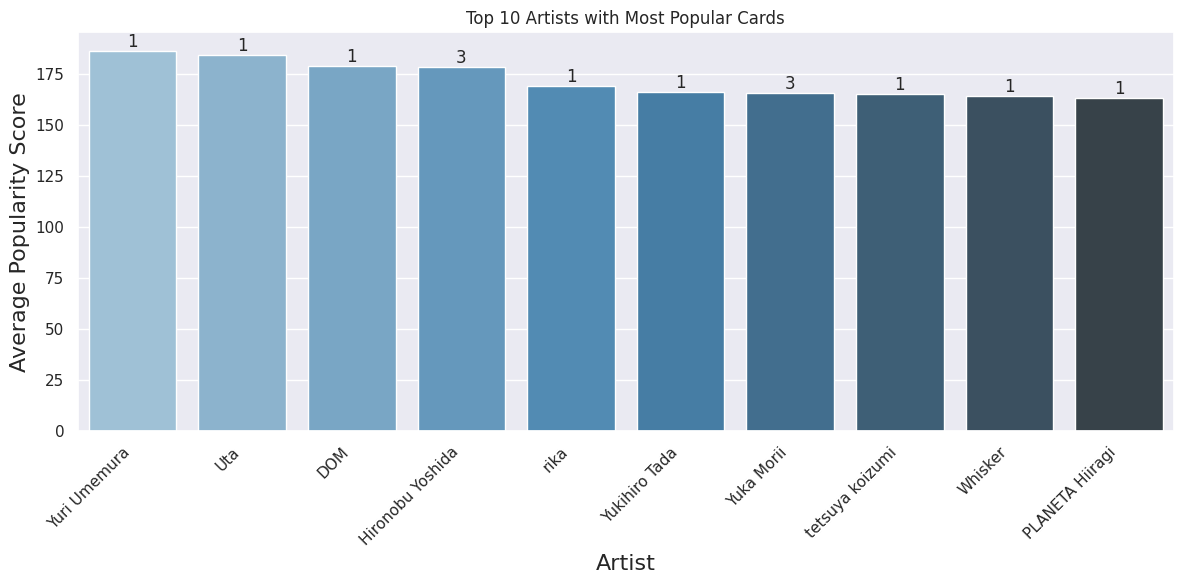

In [48]:

artist_stats = data[data['processed_popularity'] != -1].groupby('artist').agg({
    'processed_popularity': 'mean',
    'name': 'count'
}).reset_index()

top_artists = artist_stats.nlargest(10, 'processed_popularity')

plt.figure(figsize=(12, 6))
sns.barplot(
    x=top_artists['artist'],
    y=top_artists['processed_popularity'],
    palette='Blues_d'
)

plt.title('Top 10 Artists with Most Popular Cards')

for i, (value, count) in enumerate(zip(top_artists['processed_popularity'], top_artists['name'])):
    plt.text(i, value, f'{count}', ha='center', va='bottom')

plt.xlabel('Artist', fontsize=16)
plt.ylabel('Average Popularity Score', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

As for the top 10 artists with the most popular Pokémon, the study appears to be somewhat biased, as the artists in the top 10 have only one or two observations. For this reason, we are revisiting the study, this time focusing only on the artists who have at least five observations.

<ipython-input-55-e30635139799>:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




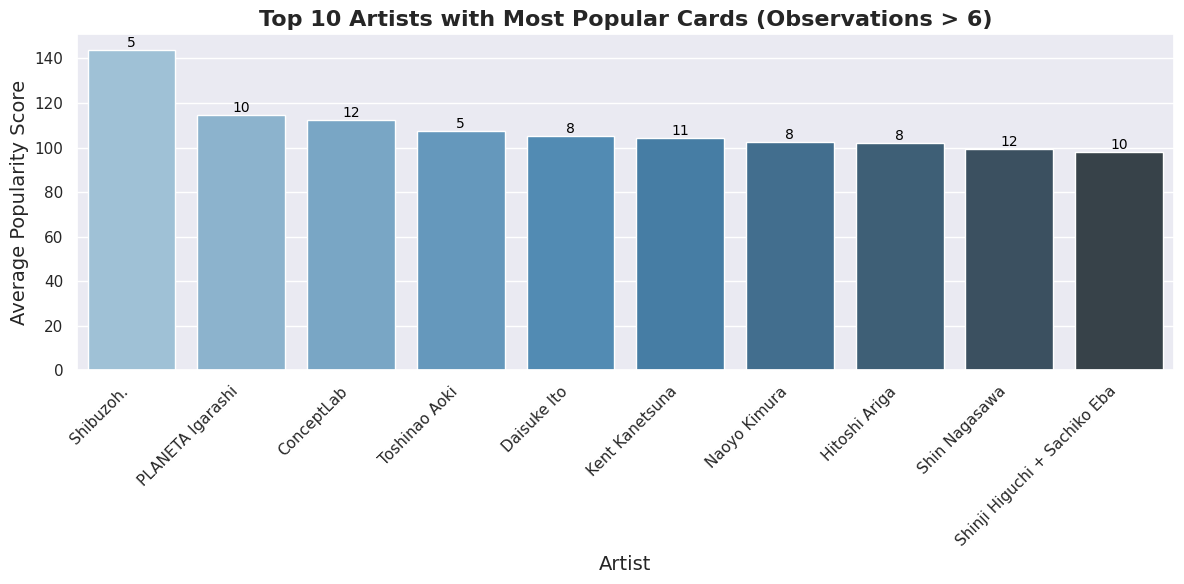

In [55]:

artist_stats = data[data['processed_popularity'] != -1].groupby('artist').agg({
    'processed_popularity': 'mean',
    'name': 'count'
}).reset_index()

# Filtrer les artistes avec un nombre d'observations > 4
filtered_artists = artist_stats[artist_stats['name'] > 4]

top_artists = filtered_artists.nlargest(10, 'processed_popularity')

plt.figure(figsize=(12, 6))
sns.barplot(
    x=top_artists['artist'],
    y=top_artists['processed_popularity'],
    palette='Blues_d'
)

plt.title('Top 10 Artists with Most Popular Cards (Observations > 6)', fontsize=16, weight='bold')

for i, (value, count) in enumerate(zip(top_artists['processed_popularity'], top_artists['name'])):
    plt.text(i, value, f'{count}', ha='center', va='bottom', fontsize=10, color='black')

plt.xlabel('Artist', fontsize=14)
plt.ylabel('Average Popularity Score', fontsize=14)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()


With this filtering, we find the artist Naoyo Kimura in the top 10. It is noteworthy that Naoyo Kimura appears in both the top 10 for price and popularity, which could suggest that if a card is produced by this artist, it tends to be both popular and expensive. This could partially explain the price of a card, and this is exactly what the linear regression analysis reveals from the data.